# environment setting

1. aiffel env copy
2. git clone and build

       git clone https://github.com/fizyr/keras-retinanet.git
       cd keras-retinanet && python setup.py build_ext --inplace

4. pip install

       pip install -r requirements.txt
       pip install .

# import lib

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

# Kitti Dataset Load
- http://www.cvlibs.net/datasets/kitti/

In [2]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

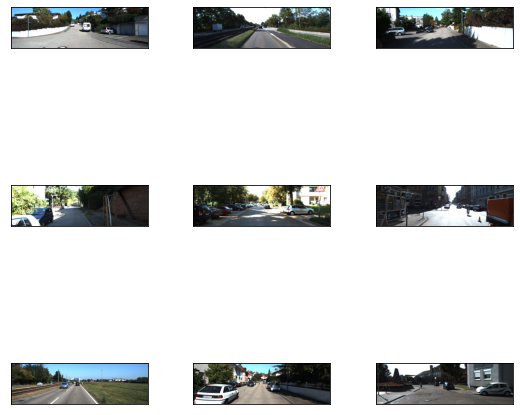

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

## 데이터셋 크기
- 7,481개의 학습 데이터(training data)
- 711개의 평가용 데이터(test data)
- 423개의 검증용 데이터(validation data)

## 데이터 확인하기

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.78, 1.05], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.21997334, 0.32399356, 0.49829334, 0.44334945],
       [0.41554666, 0.7607488 , 0.5737067 , 0.77765703]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.43, 1.66, 3.67],
       [1.74, 0.47, 0.55]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1 ,  1.72, 12.11],
       [10.24,  1.36, 21.53]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.61, 1.49], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>}


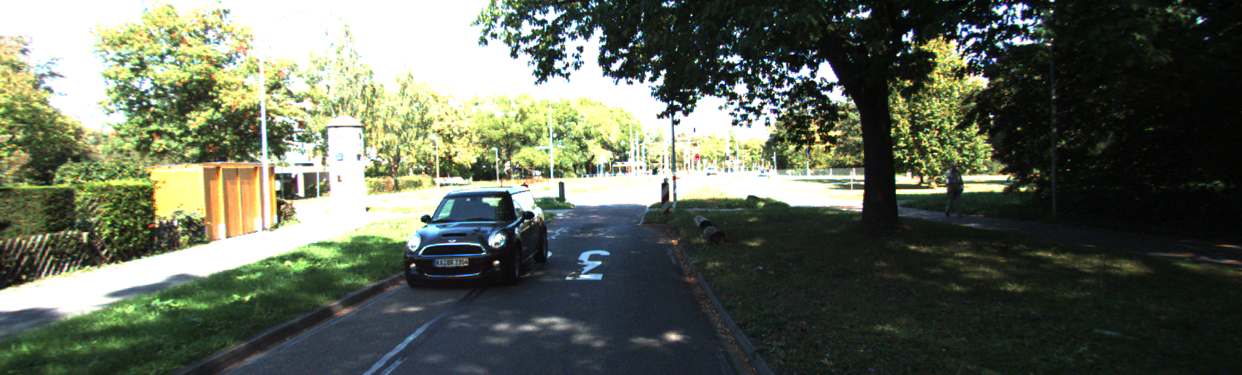

In [6]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
<pre>
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',   
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',   
                     'Misc' or 'DontCare'   
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where   
                     truncated refers to the object leaving image boundaries   
   1    occluded     Integer (0,1,2,3) indicating occlusion state:   
                     0 = fully visible, 1 = partly occluded   
                     2 = largely occluded, 3 = unknown   
   1    alpha        Observation angle of object, ranging [-pi..pi]   
   4    bbox         2D bounding box of object in the image (0-based index):   
                     contains left, top, right, bottom pixel coordinates   
   3    dimensions   3D object dimensions: height, width, length (in meters)   
   3    location     3D object location x,y,z in camera coordinates (in meters)   
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]   
   1    score        Only for results: Float, indicating confidence in   
                     detection, needed for p/r curves, higher is better.   
</pre>

## Bounding box 그리기

<code>bbox = left, top, right, bottom pixel
x_min = top, x_max = bottom
y_min = h - left, y_max = h - right</code>

[[0.21997334 0.32399356 0.49829334 0.44334945]
 [0.41554666 0.7607488  0.5737067  0.77765703]]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F27F45D1590>


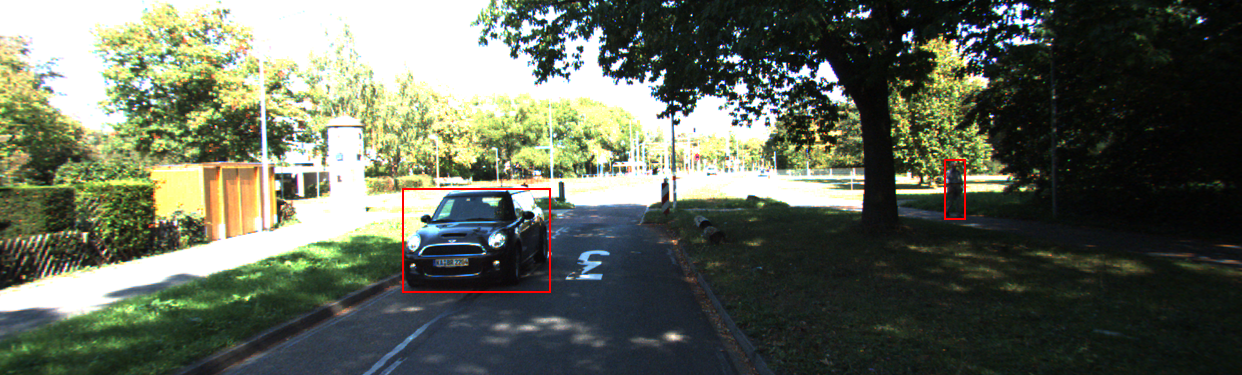

In [7]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # [[YOUR CODE]]
    w, h = input_image.size
    print(object_bbox)
    # w는 가르, h는 세로
    # 
    x_a, x_b = object_bbox[:, 1]*w, object_bbox[:, 3]*w,
    y_a, y_b = h - object_bbox[:, 0]*h, h - object_bbox[:, 2]*h
    # 바운딩 박스 그리기
    # [[YOUR CODE]]
    for i in range(object_bbox.shape[0]):
        draw.rectangle([x_a[i], y_a[i], x_b[i], y_b[i]], width=2, outline='red')
    print(input_image)
    return input_image
    
visualize_bbox(img, objects['bbox'].numpy())

# RetinaNet

https://github.com/fizyr/keras-retinanet

## Dataset format change
- tqdm : https://github.com/tqdm/tqdm
- pd.append : https://emilkwak.github.io/dataframe-list-row-append-ignore-index

<code>bbox = left, top, right, bottom pixel
x_min = top, x_max = bottom
y_min = h - left, y_max = h - right</code>

In [8]:
import os
data_dir = '/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/data'
img_dir = '/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/data/kitti_images/'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        # 코드 구현
        # image, filename, objects
        filename = item["image/file_name"].numpy().decode('utf-8')
        img_path = img_dir + filename
        
        image = Image.fromarray(item["image"].numpy())
        if not os.path.exists(img_path):
            image.save(img_path)
        objects = item["objects"]
        
        # 좌표 계산
        w, h = image.size[:2]
        coordinate = objects['bbox'].numpy()
        x_a, x_b = coordinate[:, 1]*w, coordinate[:, 3]*w,
        y_a, y_b = h - coordinate[:, 2]*h, h - coordinate[:, 0]*h
        rects = np.stack([x_a, y_a, x_b, y_b], axis=1).astype(np.int)

        # class_types list
        class_types = objects['type'].numpy()
        
#         tmp = []
        for i, rect in enumerate(rects):
            _type = class_types[i]
            if _type not in type_class_map.keys():
                continue
            dict_ = {}
            dict_['img_path'] = img_dir + filename
            dict_['x1'] = rect[0]
            dict_['y1'] = rect[1]
            dict_['x2'] = rect[2]
            dict_['y2'] = rect[3]
            dict_['class_name'] = type_class_map[class_types[i]]
#             tmp.append(dict_)
            df = df.append(dict_, ignore_index=True)
#     print(df)
    return df

if not os.path.exists(train_csv_path):
    df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
    df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

In [9]:
test_csv_path = data_dir + '/kitti_test.csv'

if not os.path.exists(test_csv_path):
    df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
    df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

In [10]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    # 코드 구현
    class_type_num = {
        'car': 0,
        'person': 1
    }
    with open(path, 'w', encoding='utf-8') as f:
        for k, v in class_type_num.items():
            f.write(f'{k},{v}\n')

save_class_format(class_txt_path)

## Setting
- ram 8기가도 부족할 수 있음   
    https://github.com/fizyr/keras-retinanet/issues/499
- pip install progressbar

In [11]:
!pip install progressbar2

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다.
if not os.path.exists('./snapshots/resnet50_csv_50.h5'):
    !python ~/aiffel/Going_Deeper/3.object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv /home/aiffel0049/aiffel/Going_Deeper/3.object_detection/data/kitti_train.csv ~/aiffel/Going_Deeper/3.object_detection/data/classes.txt

Traceback (most recent call last):
  File "/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/keras-retinanet/keras_retinanet/bin/train.py", line 553, in <module>
    main()
  File "/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/keras-retinanet/keras_retinanet/bin/train.py", line 469, in main
    backbone = models.backbone(args.backbone)
  File "/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/keras-retinanet/keras_retinanet/bin/../../keras_retinanet/models/__init__.py", line 57, in backbone
    from .resnet import ResNetBackbone as b
  File "/home/aiffel0049/aiffel/Going_Deeper/3.object_detection/keras-retinanet/keras_retinanet/bin/../../keras_retinanet/models/resnet.py", line 18, in <module>
    import keras_resnet
ModuleNotFoundError: No module named 'keras_resnet'
